In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [2]:
import sys
sys.path.append("../dnn_from_scratch")

In [3]:
import cifar_pre_process
dt = cifar_pre_process.CifarPreProcess()
dt.set_up_images()

/usr/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWarning: Passing (type, 1)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [4]:
X_train=np.concatenate([dt.training_images,dt.test_images]).reshape(-1,32,32,3)*2-1

In [5]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,conv2d,upsampling,reshape,BatchNormalization,Activation
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 930
Seed: 861


In [6]:
def generator():
    model=Sequential()
    model.add(dense(128*8*8,activation=functions.leakyRelu,input_shape=100))
    model.add(reshape((8,8,128)))
    model.add(upsampling())
#     model.add(dropout(0.25))
    model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(upsampling())
#     model.add(dropout(0.25))
    model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu))
    model.add(BatchNormalization())
#     model.add(dropout(0.2))
    model.add(conv2d(3,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 8192)               leakyRelu        827392
__________________________________________________________________________________________
2 reshape(reshape)        (None, 8, 8, 128)          echo             0
__________________________________________________________________________________________
3 upsampling(upsampling)  (None, 16, 16, 128)        echo             0
__________________________________________________________________________________________
4 conv2d(conv2d)          (None, 16, 16, 64)         leakyRelu        73792
__________________________________________________________________________________________
5 Batch

In [7]:
def discriminator():
    model=Sequential()
    model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu,input_shape=(32,32,3)))
    model.add(max_pool())
    model.add(dropout(0.25))
    model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(max_pool())
    model.add(BatchNormalization())
    model.add(dropout(0.25))
    model.add(flatten())
    model.add(dense(256,activation=functions.leakyRelu))
    model.add(dropout(0.25))
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 32, 32, 3)          echo             0
__________________________________________________________________________________________
1 conv2d(conv2d)          (None, 32, 32, 32)         leakyRelu        896
__________________________________________________________________________________________
2 max_pool(max_pool)      (None, 16, 16, 32)         echo             0
__________________________________________________________________________________________
3 dropout(dropout)        (None, 16, 16, 32)         echo             0
__________________________________________________________________________________________
4 conv2d(conv2d)          (None, 16, 16, 64)         leakyRelu        18496
__________________________________________________________________________________________
5 max_pool

In [8]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.002)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.002)

In [9]:
def gen_sample():
    noise=np.random.randn(1,100).astype(np.float32)
    gen=g.predict(noise)
    plt.imshow((gen[0]+1)/2,interpolation='bicubic')
    plt.show()
    print(d.predict(gen)[0])

In [10]:
def run():
    batch_size=64
    dsz=X_train.shape[0]
    # Label real ones as 90% real
    y_fake=np.zeros((batch_size,1),dtype=np.float32)
    y_real=np.ones((batch_size,1),dtype=np.float32)
    y_gen=np.ones((batch_size,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
#         X = np.concatenate([real_images,generated_images])
        # Train discriminator
        y_real=np.random.uniform(0.9,1,(batch_size,1)).astype(np.float32)
        y_fake=np.random.uniform(0,0.1,(batch_size,1)).astype(np.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
        # Treat noised input of generator as real data
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        if not step%50:
            gen_sample()
        print("\rProgress: {:.2f} %     Dloss: {}    err: {}     Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,dloss,abs(err).mean(),time()-stt),end='')

EPOCH: 1 / 2


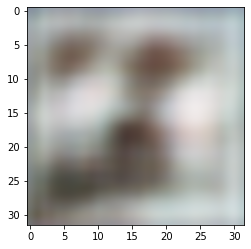

[0.74557686]
Progress: 5.23 %     Dloss: 40.04541015625    err: 0.0061226352117955685     Sample time: 1.127s    _ __

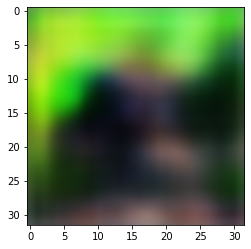

[0.00127967]
Progress: 10.56 %     Dloss: 46.378143310546875    err: 0.009529388509690762     Sample time: 1.609s    _

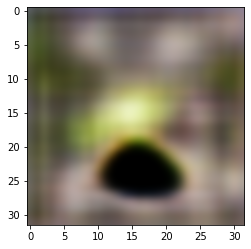

[0.16866504]
Progress: 15.89 %     Dloss: 33.656898498535156    err: 0.012017381377518177     Sample time: 1.160s    _

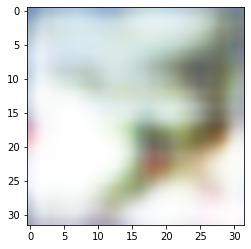

[0.6915801]
Progress: 21.23 %     Dloss: 32.306190490722656    err: 0.008339352905750275     Sample time: 1.289s    _

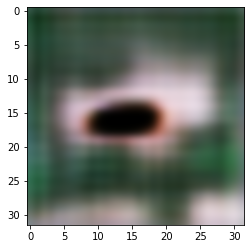

[0.2617785]
Progress: 26.56 %     Dloss: 33.34642028808594    err: 0.009588201530277729     Sample time: 1.821s    __

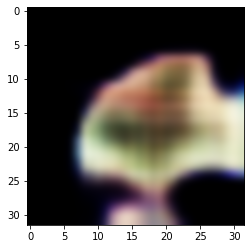

[0.02662843]
Progress: 31.89 %     Dloss: 30.2780704498291    err: 0.011565006338059902     Sample time: 1.141s    ___

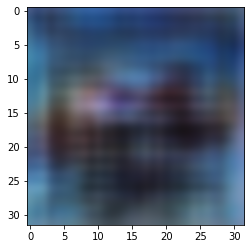

[0.49374622]
Progress: 37.23 %     Dloss: 28.76220703125    err: 0.00923369824886322     Sample time: 1.254s    _    __

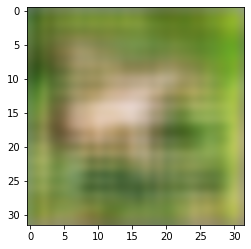

[0.68245494]
Progress: 42.56 %     Dloss: 44.476253509521484    err: 0.007432600017637014     Sample time: 1.263s    _

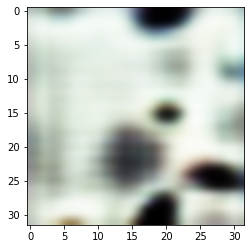

[0.82242703]
Progress: 47.89 %     Dloss: 44.736454010009766    err: 0.010243059135973454     Sample time: 1.142s    __

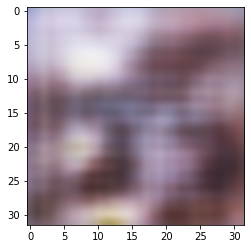

[0.11056401]
Progress: 53.23 %     Dloss: 19.445432662963867    err: 0.006888188421726227     Sample time: 1.135s    __

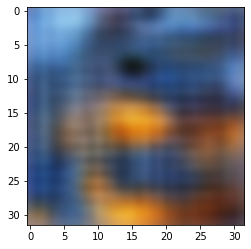

[0.094727]
Progress: 58.56 %     Dloss: 22.059297561645508    err: 0.010096303187310696     Sample time: 1.300s    __

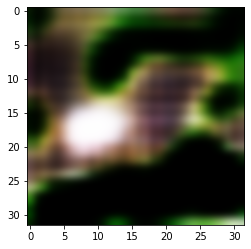

[0.87330174]
Progress: 63.89 %     Dloss: 60.30298614501953    err: 0.010317126289010048     Sample time: 1.173s    __

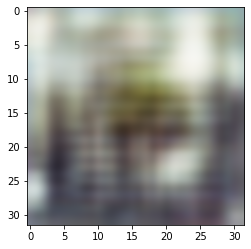

[0.23563416]
Progress: 69.23 %     Dloss: 29.190603256225586    err: 0.007308091502636671     Sample time: 1.292s    __

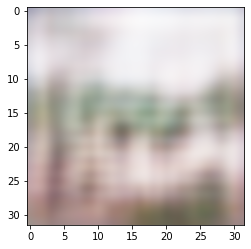

[0.4791232]
Progress: 74.56 %     Dloss: 24.421287536621094    err: 0.010113646276295185     Sample time: 1.227s    __

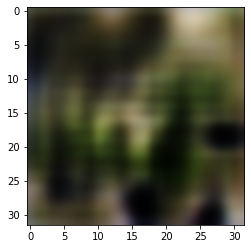

[0.00407089]
Progress: 79.89 %     Dloss: 31.561992645263672    err: 0.012867721728980541     Sample time: 1.418s    _

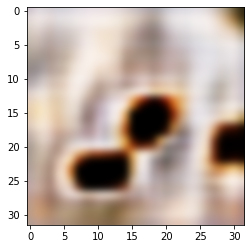

[0.20207159]
Progress: 85.23 %     Dloss: 19.459793090820312    err: 0.015512711368501186     Sample time: 1.472s    _

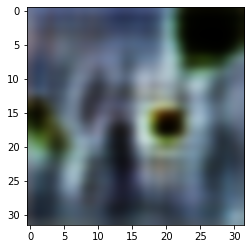

[0.19549638]
Progress: 90.56 %     Dloss: 27.729881286621094    err: 0.015617813915014267     Sample time: 1.149s    _

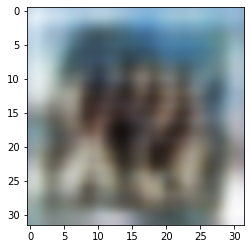

[0.21867274]
Progress: 95.89 %     Dloss: 36.71923065185547    err: 0.010282881557941437     Sample time: 1.129s    __

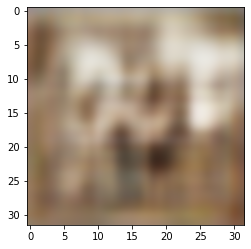

[0.87425053]
Progress: 99.84 %     Dloss: 35.80834197998047    err: 0.010803607292473316     Sample time: 1.202s    __
Epoch time: 20:16s


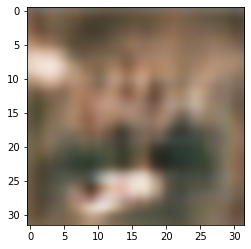

[0.17542261]
EPOCH: 2 / 2


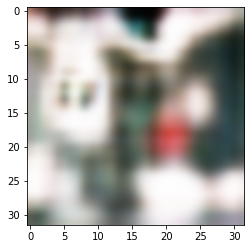

[0.9062977]
Progress: 5.23 %     Dloss: 19.457664489746094    err: 0.015646440908312798     Sample time: 1.133s    _

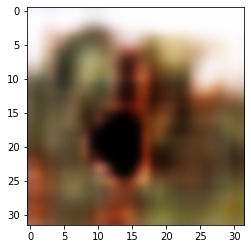

[0.48438677]
Progress: 10.56 %     Dloss: 33.80293273925781    err: 0.009870157577097416     Sample time: 1.161s    __

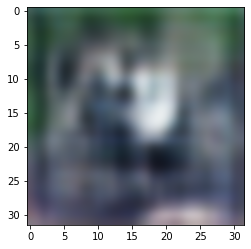

[0.4872586]
Progress: 15.89 %     Dloss: 41.55205535888672    err: 0.012413560412824154     Sample time: 1.148s    __

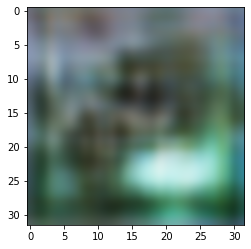

[0.6931675]
Progress: 21.23 %     Dloss: 27.029769897460938    err: 0.008529462851583958     Sample time: 1.381s    _

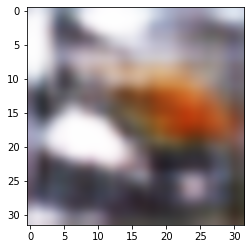

[0.355963]
Progress: 26.56 %     Dloss: 33.512393951416016    err: 0.010757011361420155     Sample time: 1.216s    _

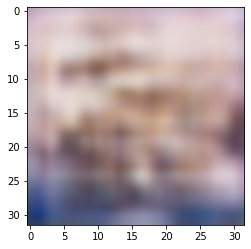

[0.8517628]
Progress: 31.89 %     Dloss: 36.640167236328125    err: 0.012322030030190945     Sample time: 1.152s    _

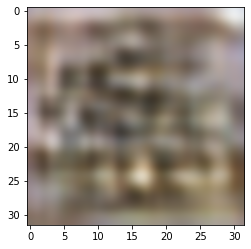

[0.00652644]
Progress: 37.23 %     Dloss: 22.966516494750977    err: 0.010930282063782215     Sample time: 1.149s    _

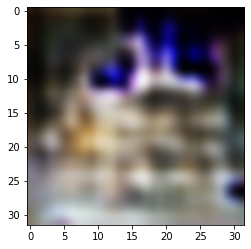

[0.01034656]
Progress: 42.56 %     Dloss: 34.681549072265625    err: 0.01177260372787714     Sample time: 1.146s    __

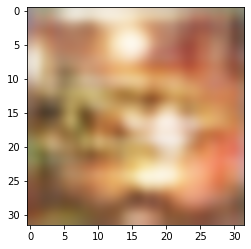

[0.66106105]
Progress: 47.89 %     Dloss: 23.972084045410156    err: 0.014022402465343475     Sample time: 1.235s    _

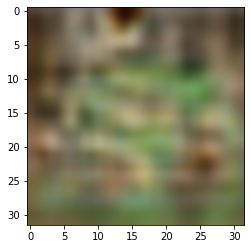

[0.25448388]
Progress: 53.23 %     Dloss: 24.95524024963379    err: 0.014630258083343506     Sample time: 1.158s    __

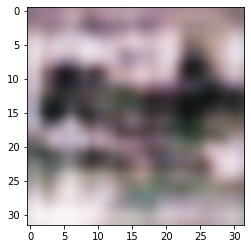

[0.08668762]
Progress: 58.56 %     Dloss: 23.296531677246094    err: 0.015798339620232582     Sample time: 1.201s    _

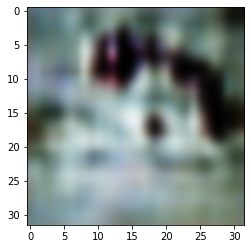

[0.09262967]
Progress: 63.89 %     Dloss: 35.458396911621094    err: 0.013152793049812317     Sample time: 1.142s    _

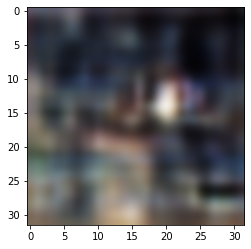

[0.09756944]
Progress: 69.23 %     Dloss: 34.230934143066406    err: 0.014830607920885086     Sample time: 1.188s    _

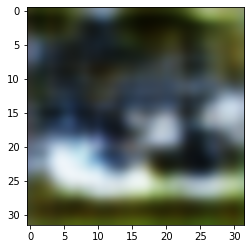

[0.73162544]
Progress: 74.56 %     Dloss: 44.693416595458984    err: 0.014014381915330887     Sample time: 1.138s    _

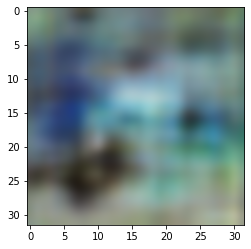

[0.44621888]
Progress: 79.89 %     Dloss: 26.202407836914062    err: 0.017811184749007225     Sample time: 1.349s    _

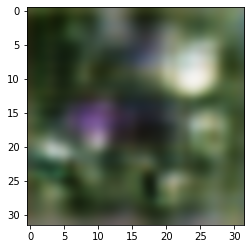

[0.76272917]
Progress: 85.23 %     Dloss: 33.57164001464844    err: 0.014732599258422852     Sample time: 1.185s    __

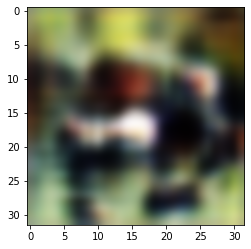

[0.21805078]
Progress: 90.56 %     Dloss: 33.874019622802734    err: 0.015953436493873596     Sample time: 1.450s    _

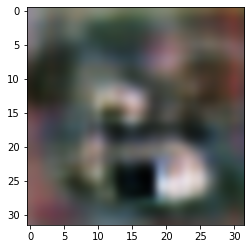

[0.21102023]
Progress: 95.89 %     Dloss: 27.27548599243164    err: 0.02032640390098095     Sample time: 1.388s    ___

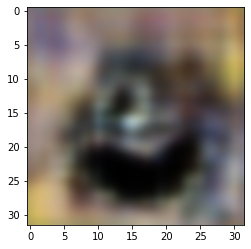

[0.33027196]
Progress: 99.84 %     Dloss: 34.09562683105469    err: 0.011779478751122952     Sample time: 1.509s    __
Epoch time: 20:7s


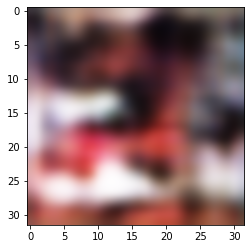

[0.43263867]


In [14]:
epochs=2
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    gen_sample()

## # Using generator with just batch size 1 for first time is causing images to be generated extreme

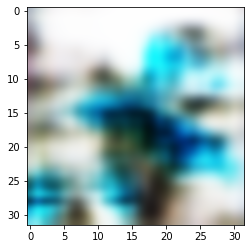

In [ ]:
noise=np.random.randn(128,100).astype(np.float32)
gen=g.predict(noise)
gen_sample()
img=X_train[np.random.randint(low=0,high=X_train.shape[0],size=1)]
plt.imshow((img[0]+1)/2,interpolation='bicubic')
plt.show()
print(d.predict(img))

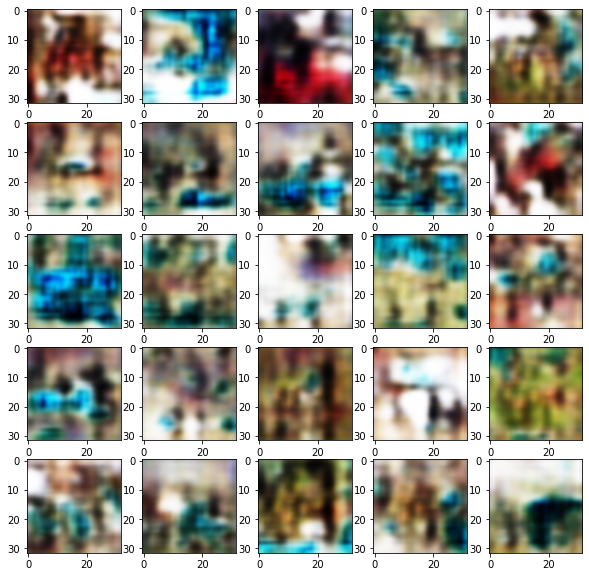

In [33]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
noise=np.random.randn(25,100).astype(np.float32)
gen=g.predict(noise)
for i,axi in enumerate(ax.flat):
    axi.imshow((gen[i].squeeze()+1)/2,interpolation='bicubic')